# GENERAL INSPECTION

## SET UP

In [1]:
# Unified script to load epochs, build evokeds,
# compute both group-level and ROI-level cumulative SNR.
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import numpy as np
import mne
import pandas as pd
from copy import deepcopy
from mne import grand_average
mne.set_log_level('WARNING')

# -----------------------------------------------------------------------------
# 1) Setup: paths, subjects, parameters
# -----------------------------------------------------------------------------

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Define data paths relative to the project root
data_path = os.path.join(project_root, "data", "1_raw")
#save_to_data_path = os.path.join("plots", "erp")

# Subjects
subjects = [
    "sub-bravoc001", "sub-bravoc002", "sub-bravoc003", "sub-bravoc004",
    "sub-bravoc006", "sub-bravoc007", "sub-bravoc008", "sub-bravoc009",
    "sub-bravoc011", "sub-bravoc012", "sub-bravoc013", "sub-bravoc014",
    "sub-bravoc016", "sub-bravoc017", "sub-bravoc018", "sub-bravoc019",
    "sub-bravoc020", "sub-bravoc022", "sub-bravoc025", "sub-bravoc026",
    "sub-bravoc027", "sub-bravoc028", "sub-bravoc029", "sub-bravoc030",
    "sub-bravoc032", "sub-bravoc033", "sub-bravoc035", "sub-bravoc036",
    "sub-bravoc037", "sub-bravoc040", "sub-bravoc041", "sub-bravoc042",
    "sub-bravoc043", "sub-bravoc044", "sub-bravoc045", "sub-bravoc046",
    "sub-bravoc049", "sub-bravoc050", "sub-bravoc051", "sub-bravoc052"
]

# subjects = ["sub-bravoc001", "sub-bravoc006", "sub-bravoc009", "sub-bravoc011", "sub-bravoc012", "sub-bravoc017", "sub-bravoc018", "sub-bravoc019", "sub-bravoc020", "sub-bravoc028", "sub-bravoc032", "sub-bravoc036", "sub-bravoc037", "sub-bravoc041", "sub-bravoc050"]

# Time windows (seconds)
baseline   = (-0.100, 0.0)
signal_win = (0.285, 0.345)

# Tasks and conditions (for evoked_dict)
tasks      = ["nouns"]
conditions = {"nouns": ['a', 'f', 't', 'c', 'e', 's']}

# ROI channels
roi = [
    "FC1","FCz","FC2","FCC1h","FCC2h",
    "C1","Cz","C2","CCP1h","CCP2h",
    "CP1","CPz","CP2","CPP1h","CPP2h"
]


# Label mapping (optional)
label_mapping_nouns = {
    "a": "Animal",
    "f": "Food",
    "t": "Tool",
    "c": "Communication",
    "e": "Emotion",
    "s": "Social"
}


# -----------------------------------------------------------------------------
# 2) Load epochs & build evoked_dict
# -----------------------------------------------------------------------------

# Storage
epochs_dict  = {}  # subject -> Epochs
evoked_dict  = {str(rep): {cond: [] for cond in conditions['nouns']} for rep in range(1,7)}
included_subjects = []

for subject in subjects:
    
    epo = mne.read_epochs(
        os.path.join(data_path, f"{subject}/preprocessed-epo/{subject}_task-nouns_eeg-epo_100_70_cutoff.fif")
    )
    epochs_dict[subject] = epo

    all_names = list(epo.event_id.keys())
    for rep in range(1,7):
        for cond in conditions['nouns']:
            names = [n for n in all_names if f"/{rep}/{cond}/n" in n]
            if not names:
                continue
            ev = epo[names].average()
            evoked_dict[str(rep)][cond].append(ev)

    included_subjects.append(subject)


/var/folders/p5/822n7fz95t7bzj627vx8cf3r0000gn/T/ipykernel_32534/177147630.py:77: RuntimeWarning: This filename (/Users/johannberger/Documents/thesis/data/1_raw/sub-bravoc001/preprocessed-epo/sub-bravoc001_task-nouns_eeg-epo_100_70_cutoff.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epo = mne.read_epochs(
/var/folders/p5/822n7fz95t7bzj627vx8cf3r0000gn/T/ipykernel_32534/177147630.py:77: RuntimeWarning: This filename (/Users/johannberger/Documents/thesis/data/1_raw/sub-bravoc002/preprocessed-epo/sub-bravoc002_task-nouns_eeg-epo_100_70_cutoff.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epo = mne.read_epochs(
/var/folders/p5/822n7fz95t7bzj627vx8cf3r0000gn/T/ipykernel_32534/177147630.py:77: RuntimeWarning: This filename (/Users/johannberger/Documents/thesis/data/1_raw/sub-bravoc003/preprocessed-epo/sub-bravoc003_task-nou

## PLOTS

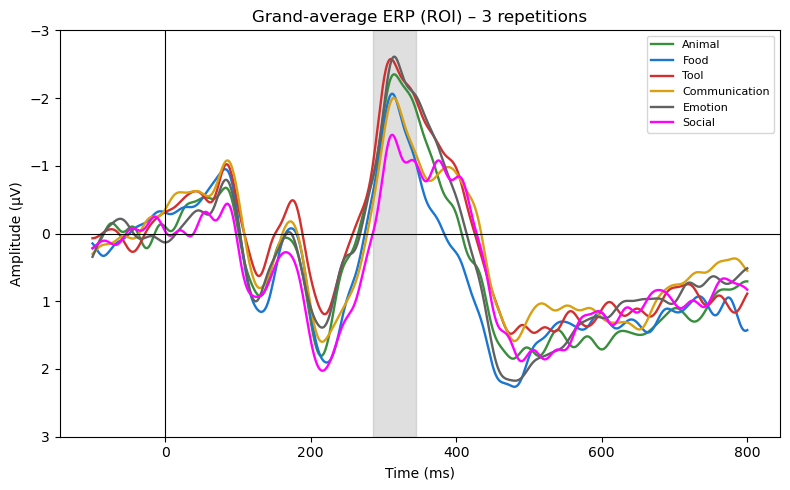

In [ ]:
# ERP plot: negative up, Okabe–Ito colors, shaded window, variable #reps
# ------------------------------------------------------------------
n_reps_to_use = 6         # <-- change this number (1 … 6)
assert 1 <= n_reps_to_use <= 6

# Build a dict with the evokeds we actually want
evokeds_for_plot = {cond: [] for cond in conditions['nouns']}
for rep in range(1, n_reps_to_use + 1):
    for cond in conditions['nouns']:
        evokeds_for_plot[cond].extend(evoked_dict[str(rep)][cond])

# Grand-average per category
grand_evokeds = {cond: grand_average(evokeds_for_plot[cond])
                 for cond in conditions['nouns']}

# Okabe–Ito palette
colors = ['#388E3C', '#1976D2', '#D32F2F', '#d9a00f',
          '#616161', '#ff00ff']

# ----------------------------------------------------------
# ROI AVERAGE
# ----------------------------------------------------------
pick_roi = mne.pick_channels(grand_evokeds['a'].ch_names, include=(roi))
roi_data = {
    cond: grand_evokeds[cond].data[pick_roi, :].mean(axis=0) * 1e6   # µV
    for cond in conditions['nouns']
}

fig, ax = plt.subplots(figsize=(8, 5))
for color, cond in zip(colors, conditions['nouns']):
    ax.plot(grand_evokeds[cond].times * 1e3, roi_data[cond],
            label=label_mapping_nouns[cond], color=color, linewidth=1.7)

# Shade the signal window
ax.axvspan(signal_win[0]*1e3, signal_win[1]*1e3,
           color='grey', alpha=0.25, zorder=0)

# Flip y-axis (negative up) + manual limits
ax.invert_yaxis()
ax.set_ylim(3, -3)

# Zero lines
ax.axhline(0, color='k', linewidth=0.8)
ax.axvline(0, color='k', linewidth=0.8)

# Labels & finish
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (µV)')
ax.set_title(f'Grand-average ERP (ROI) – {n_reps_to_use} repetitions')
ax.legend(loc='upper right', fontsize=8)
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
fig.tight_layout()
# Save the plot as an SVG file
fig.savefig('ERPplot1-6.pdf', format='pdf')
plt.show()

## ANALYSIS PREPARATION

### Set Up

In [ ]:
# Setup

experiment = tasks[0]
time_window = signal_win
baseline_window = baseline

time_start_ms = int(time_window[0] * 1000)
time_end_ms   = int(time_window[1] * 1000)

# This is now a *directory* for all the per-subject CSVs
save_to_csv_path = os.path.join(project_root, "data", "2_preprocessed", f"{time_start_ms}-{time_end_ms}ms")
# Ensure the directory exists
os.makedirs(save_to_csv_path, exist_ok=True)


In [ ]:
# Export per-subject CSVs and collect

df_list = []
for subject in included_subjects:
    epochs_file = os.path.join(
        data_path,
        subject,
        f"preprocessed-epo/{subject}_task-{experiment}_eeg-epo_100_70_cutoff.fif"
    )
    if not os.path.exists(epochs_file):
        print(f"File not found: {epochs_file}")
        continue

    print(f"Processing: {subject}")
    epochs = mne.read_epochs(epochs_file, preload=True)
    epochs.apply_baseline(baseline_window)

    # To long-format DataFrame
    df = epochs.to_data_frame()
    df.insert(0, 'subject', subject)
    df['repetition'] = df['condition'].apply(lambda x: x.split("/")[1])
    
    # Normalize time column to seconds (handles both ms and s representations)
    df['time'] = df['time'].astype(float)
    if df['time'].abs().max() > 10:  # heuristic: large values imply milliseconds
        df['time'] = df['time'] / 1000.0

    # Filter for window and compute mean
    df_w = df[(df['time'] >= time_window[0]) & (df['time'] <= time_window[1])]
    df_w_mean = df_w.groupby(
        ['epoch', 'subject', 'condition'],
        as_index=False
    ).mean(numeric_only=True)

    # Save individual CSV
    out_file = os.path.join(
        save_to_csv_path,
        f"{subject}_task-{experiment}_{time_start_ms}-{time_end_ms}ms.csv"
    )
    df_w_mean.to_csv(out_file, index=False)
    print(f"Saved: {out_file}")
    df_list.append(df_w_mean)
    


In [ ]:
# Combine all subjects and transform
# --------------------

# Concatenate
if df_list:
    df_all = pd.concat(df_list, ignore_index=True)
    
    bad_conditions = df_all[~df_all['condition'].str.contains("/", regex=False)]
    print("⚠️ Bad condition rows:")
    print(bad_conditions)

    # Parse condition into separate columns
    parts = df_all['condition'].str.split('/', expand=True)
    df_all['item']       = parts.iloc[:, 0]
    df_all['repetition'] = parts.iloc[:, 1].astype(int)
    df_all['category']   = parts.iloc[:, 2].map({
        'a': 'animal',
        'c': 'commun',
        'e': 'emotion',
        'f': 'food',
        's': 'social',
        't': 'tool'
})

    # Drop unwanted columns
    df_all.drop(columns=['condition', 'epoch', 'time'], inplace=True)

    # Pivot to long format (channels->voltage)
    id_vars = ['subject', 'item', 'repetition', 'category']
    channel_cols = [c for c in df_all.columns if c not in id_vars]
    df_long = df_all.melt(
        id_vars=id_vars,
        value_vars=channel_cols,
        var_name='channel',
        value_name='voltage'
    )

    # Save combined CSV
    combined_file = os.path.join(
        save_to_csv_path,
        f"combined_task-{experiment}_{time_start_ms}-{time_end_ms}ms.csv"
    )
    df_long.to_csv(combined_file, index=False)
    print(f"Saved combined file: {combined_file}")
else:
    print("No dataframes collected; check your subject list.")


# SIGNAL TO NOISE RATIO

/var/folders/p5/822n7fz95t7bzj627vx8cf3r0000gn/T/ipykernel_81973/483024398.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  cumul = rep_epo if cumul is None else mne.concatenate_epochs([cumul, rep_epo])
/var/folders/p5/822n7fz95t7bzj627vx8cf3r0000gn/T/ipykernel_81973/483024398.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  cumul = rep_epo if cumul is None else mne.concatenate_epochs([cumul, rep_epo])
/var/folders/p5/822n7fz95t7bzj627vx8cf3r0000gn/T/ipykernel_81973/483024398.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  cumul = rep_epo if cumul is None else mne.concatenate_epochs([cumul, rep_epo])
/var/folders/p5/822n7fz95t7bzj627vx8cf3r0000gn/T/ipykernel_81973/483024398.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All an

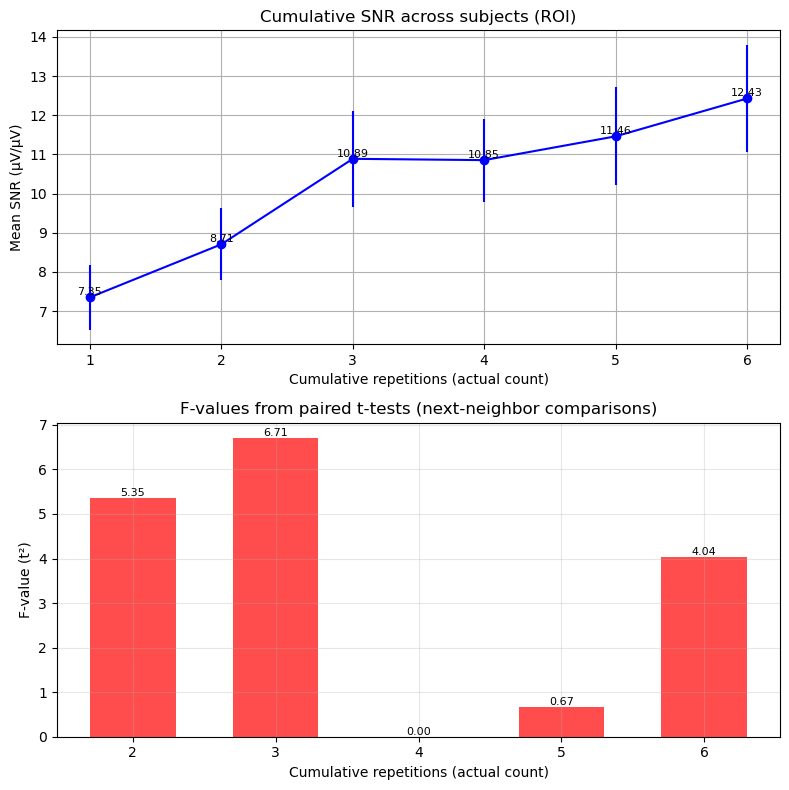

SNR data exported to: /Users/johannberger/Documents/thesis/data/3_analysis/cumulative_snr_data.csv
F-value data exported to: /Users/johannberger/Documents/thesis/data/3_analysis/f_values_data.csv
Complete analysis exported to: /Users/johannberger/Documents/thesis/data/3_analysis/complete_snr_analysis.csv


,cum_reps,mean,sem,delta_abs,delta_pct,paired_t_p,holm_sig,tost_p_lower,tost_p_upper,tost_equivalent,plateau_rule,compared_to,f_value
0,1,7.353248,0.832234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
1,2,8.706348,0.919398,1.353100,18.401390,0.026092,False,0.002737,0.949959,False,False,1.0,5.349562
2,3,10.887568,1.231569,2.181220,25.053217,0.013412,False,0.001757,0.977609,False,False,2.0,6.710355
3,4,10.854039,1.057107,-0.033529,-0.307953,0.960265,False,0.224740,0.196366,False,True,3.0,0.002514
4,5,11.461298,1.246244,0.607259,5.594771,0.419493,False,0.065196,0.534339,False,False,4.0,0.665750
5,6,12.427326,1.374553,0.966028,8.428612,0.051505,False,0.001363,0.790608,False,False,5.0,4.035734


In [5]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import stats
import re

# ============================================================
# =============== USER-DEFINED / EXISTING INPUTS =============
# These must already exist in your environment:
# - epochs_dict: dict[str -> mne.Epochs]
# - subjects:    list[str]
# - roi:         list[str] (channel names)
# - baseline:    tuple[float, float] in seconds, e.g. (-0.2, 0)
# - signal_win:  tuple[float, float] in seconds, e.g. (0.05, 0.2)
# ============================================================

# ========== PARAMETERS ==========
max_rep = 6                          # adjust if needed
equivalence_pct = 0.05               # ±5% of mean SNR at N=3 as practical equivalence margin
alpha = 0.05                         # significance level for tests

# ========== CUMULATIVE SNR BY SUBJECT ==========
# 1) Pre-compute masks (shared timing across all subjects)
_times   = next(iter(epochs_dict.values())).times
bl_mask = (_times >= baseline[0])   & (_times <= baseline[1])
sg_mask = (_times >= signal_win[0]) & (_times <= signal_win[1])

def _split_by_rep(epo: mne.Epochs, max_rep: int):
    """
    Return dict {rep_index: Epochs} for rep_index in 1..max_rep.

    Prefers epo.metadata['rep'] if present.
    Falls back to event_id name match containing '/{rep}/'.
    """
    out = {}
    # Path A: metadata column
    if epo.metadata is not None and 'rep' in epo.metadata.columns:
        for rep in range(1, max_rep+1):
            try:
                sel = epo['rep == @rep']
            except Exception:
                sel = epo.copy()[[]]  # empty
            if len(sel) > 0:
                out[rep] = sel
        return out

    # Path B: fall back to event_id name pattern (as in your original code)
    # Build index per rep using event names
    if epo.event_id is None:
        return out
    # map event_id->name for quick lookup
    inv = {v: k for k, v in epo.event_id.items()}
    # for each rep, pick events whose name contains "/rep/"
    for rep in range(1, max_rep+1):
        # collect event codes matching the name pattern
        wanted_codes = [code for code, name in inv.items() if f"/{rep}/" in name]
        if not wanted_codes:
            continue
        # select epochs whose event code is in wanted_codes
        picks = np.isin(epo.events[:, 2], wanted_codes)
        if picks.any():
            out[rep] = epo[picks]
    return out

records = []
for subj in subjects:
    epo = epochs_dict[subj].copy().pick_channels(roi)

    by_rep = _split_by_rep(epo, max_rep=max_rep)

    cumul = None
    n_added = 0  # -------- FIX 1: track *actual* cumulative count
    for rep in range(1, max_rep+1):
        rep_epo = by_rep.get(rep, None)
        if rep_epo is None or len(rep_epo) == 0:
            continue

        cumul = rep_epo if cumul is None else mne.concatenate_epochs([cumul, rep_epo])
        n_added += 1

        evoked = cumul.copy().apply_baseline(baseline).average()

        data_uv = evoked.data * 1e6  # µV
        bl_data = data_uv[:, bl_mask]
        sg_data = data_uv[:, sg_mask]

        # per-channel SNR, then average across ROI channels
        rms_noise = np.sqrt(np.mean(bl_data**2, axis=1))
        mean_sig  = np.abs(sg_data).mean(axis=1)
        snr = np.nanmean(mean_sig / rms_noise)

        records.append({'subject': subj, 'cum_reps': n_added, 'snr': snr})

df = pd.DataFrame(records)

# 3) Summarize across subjects (means/SEMs etc.)
summary = (
    df.groupby('cum_reps', as_index=False)['snr']
      .agg(mean='mean', std='std', n='count')
)
summary['sem'] = summary['std'] / np.sqrt(summary['n'])
summary['delta_abs'] = summary['mean'].diff()
summary['delta_pct'] = 100 * summary['mean'].pct_change()

# ========== FORMAL PLATEAU CHECKS ==========
# Proper Holm step-down (stop at first non-significant)
def holm_decisions(pvals_dict, alpha=0.05):
    """
    pvals_dict: {level: p_value}  (e.g., {4: 0.03, 5: 0.2, ...})
    Returns {level: bool_reject} using Holm's step-down control of FWER.
    """
    items = sorted(pvals_dict.items(), key=lambda kv: kv[1])  # ascending by p
    m = len(items)
    # initialize all to False (not significant)
    decisions = {lvl: False for lvl, _ in items}
    # step-down: stop at first failure
    for i, (lvl, p) in enumerate(items, start=1):
        thresh = alpha / (m - i + 1)
        if p <= thresh:
            decisions[lvl] = True
        else:
            break
    return decisions

# One-sided p-values for paired t-test on differences
def paired_t_one_sided(x, y, alternative):
    """
    alternative: 'greater' tests mean(x - y) > 0
                 'less'    tests mean(x - y) < 0
    """
    d = np.asarray(x) - np.asarray(y)
    d = d[~np.isnan(d)]
    n = d.size
    if n < 2:
        return np.nan
    mean_d = d.mean()
    sd_d = d.std(ddof=1)
    if sd_d == 0:
        if (alternative == 'greater' and mean_d > 0) or (alternative == 'less' and mean_d < 0):
            return 0.0
        else:
            return 1.0
    t = mean_d / (sd_d / np.sqrt(n))
    dfree = n - 1
    if alternative == 'greater':
        return stats.t.sf(t, dfree)     # P(T > t)
    else:
        return stats.t.cdf(t, dfree)    # P(T < t)

# Prepare wide table: rows=subject, cols=cum_reps (actual counts!), values=snr
wide = df.pivot_table(index='subject', columns='cum_reps', values='snr', aggfunc='mean')
available_reps = sorted([c for c in wide.columns if isinstance(c, (int, np.integer))])

# Determine equivalence margin based on N=3 group mean (for plateau rule only)
if 3 in summary['cum_reps'].values:
    snr3_mean = float(summary.loc[summary['cum_reps']==3, 'mean'])
    eq_margin_plateau = equivalence_pct * snr3_mean
else:
    snr3_mean = np.nan
    eq_margin_plateau = np.nan

# Paired t-tests (two-sided) & TOST with next-neighbor approach (N vs N-1)
ttest_pvals = {}
rows = []
for i, N in enumerate(available_reps):
    if i == 0:  # Skip first repetition as there's no previous one to compare
        rows.append({'cum_reps': N,
                     'paired_t_p': np.nan,
                     'holm_sig': np.nan,
                     'tost_p_lower': np.nan,
                     'tost_p_upper': np.nan,
                     'tost_equivalent': np.nan,
                     'compared_to': np.nan,
                     'f_value': np.nan})
        continue
    
    N_prev = available_reps[i-1]  # Previous cumulative repetition count
    
    # use only subjects with both N and N_prev
    submask = wide[[N_prev, N]].dropna()
    if submask.shape[0] < 2:
        rows.append({'cum_reps': N,
                     'paired_t_p': np.nan,
                     'holm_sig': np.nan,
                     'tost_p_lower': np.nan,
                     'tost_p_upper': np.nan,
                     'tost_equivalent': np.nan,
                     'compared_to': N_prev,
                     'f_value': np.nan})
        continue

    x = submask[N].values      # Current N
    y = submask[N_prev].values # Previous N (N-1)

    # Two-sided paired t-test
    t_stat, p_two_sided = stats.ttest_rel(x, y, nan_policy='omit')
    ttest_pvals[N] = p_two_sided
    f_value = t_stat**2  # F-value is t-squared for paired t-test

    # TOST equivalence testing with margin based on previous N mean
    # Calculate equivalence margin as percentage of previous N mean
    prev_mean = submask[N_prev].mean()
    eq_margin_adaptive = equivalence_pct * prev_mean
    
    if np.isnan(eq_margin_adaptive) or eq_margin_adaptive == 0:
        p_lower = np.nan
        p_upper = np.nan
        equivalent = np.nan
    else:
        # Test 1 (lower): mean_diff > -Δ  -> one-sided 'greater' for (diff + Δ) > 0
        diff = x - y
        p_lower = paired_t_one_sided(diff, np.zeros_like(diff) - eq_margin_adaptive, alternative='greater')
        # Test 2 (upper): mean_diff < +Δ  -> one-sided 'less' for (diff - Δ) < 0
        p_upper = paired_t_one_sided(diff, np.zeros_like(diff) + eq_margin_adaptive, alternative='less')
        equivalent = (p_lower < alpha) and (p_upper < alpha)

    rows.append({'cum_reps': N,
                 'paired_t_p': p_two_sided,
                 'tost_p_lower': p_lower,
                 'tost_p_upper': p_upper,
                 'tost_equivalent': bool(equivalent) if equivalent==equivalent else np.nan,
                 'compared_to': N_prev,
                 'f_value': f_value})

# Holm-Bonferroni correction for the paired t-tests (proper step-down)
holm = holm_decisions({k: v for k, v in ttest_pvals.items() if np.isfinite(v)}, alpha=alpha)
for r in rows:
    N = r['cum_reps']
    r['holm_sig'] = holm.get(N, np.nan)

tests = pd.DataFrame(rows).sort_values('cum_reps').reset_index(drop=True)

# Merge tests into summary
summary = summary.merge(tests, how='left', on='cum_reps')

# Optional quick rule-of-thumb plateau flag (small absolute change after N=3)
if 3 in summary['cum_reps'].values and np.isfinite(snr3_mean):
    thresh = equivalence_pct * snr3_mean
    summary['plateau_rule'] = summary['delta_abs'].abs() < thresh
else:
    summary['plateau_rule'] = np.nan

# ========== PLOT ==========
# Create subplots for SNR and F-values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Top plot: SNR
ax1.errorbar(summary['cum_reps'], summary['mean'], yerr=summary['sem'], marker='o', color='blue')
for x, y in zip(summary['cum_reps'], summary['mean']):
    ax1.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)
ax1.set_xlabel('Cumulative repetitions (actual count)')
ax1.set_ylabel('Mean SNR (µV/µV)')
ax1.set_title('Cumulative SNR across subjects (ROI)')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.grid(True)

# Bottom plot: F-values from paired t-tests
f_vals = summary['f_value'].dropna()
cum_reps_f = summary.loc[summary['f_value'].notna(), 'cum_reps']
if len(f_vals) > 0:
    ax2.bar(cum_reps_f, f_vals, alpha=0.7, color='red', width=0.6)
    for x, y in zip(cum_reps_f, f_vals):
        ax2.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)
ax2.set_xlabel('Cumulative repetitions (actual count)')
ax2.set_ylabel('F-value (t²)')
ax2.set_title('F-values from paired t-tests (next-neighbor comparisons)')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== EXPORT DATA FOR R/GGPLOT ==========
# Create output directory
export_path = os.path.join(project_root, "data", "3_analysis")
os.makedirs(export_path, exist_ok=True)

# Export SNR data for plotting
snr_data = summary[['cum_reps', 'mean', 'sem', 'delta_abs', 'delta_pct']].copy()
snr_data.rename(columns={
    'cum_reps': 'cumulative_repetitions',
    'mean': 'mean_snr',
    'sem': 'sem_snr',
    'delta_abs': 'delta_absolute',
    'delta_pct': 'delta_percent'
}, inplace=True)
snr_export_file = os.path.join(export_path, "cumulative_snr_data.csv")
snr_data.to_csv(snr_export_file, index=False)
print(f"SNR data exported to: {snr_export_file}")

# Export F-value data for plotting (only rows with valid F-values)
f_data = summary[summary['f_value'].notna()][['cum_reps', 'f_value', 'paired_t_p', 'compared_to']].copy()
f_data.rename(columns={
    'cum_reps': 'cumulative_repetitions',
    'f_value': 'f_statistic',
    'paired_t_p': 'p_value',
    'compared_to': 'comparison_baseline'
}, inplace=True)
f_export_file = os.path.join(export_path, "f_values_data.csv")
f_data.to_csv(f_export_file, index=False)
print(f"F-value data exported to: {f_export_file}")

# Export complete summary table for comprehensive analysis
complete_export_file = os.path.join(export_path, "complete_snr_analysis.csv")
summary.to_csv(complete_export_file, index=False)
print(f"Complete analysis exported to: {complete_export_file}")

# ========== OUTPUT TABLE ==========
cols = ['cum_reps','mean','sem','delta_abs','delta_pct',
        'paired_t_p','holm_sig','tost_p_lower','tost_p_upper','tost_equivalent','plateau_rule','compared_to','f_value']
display(summary[cols])

This portion of the Analysis computes the cumulative SNR which means accounting for more and more repetitions (1, 1-2, ..., 1-6). The idea is to show, how the inclusion of more data/repetitions actually improves the SNR. The main results from the statistical analysis point to the direction that 3 repetitions might be enough/best choice for future experiments. 

The results from this SNR analysis support this claim: 
| cum_reps |   mean    |   sem    | delta_abs | delta_pct  | paired_t_p | holm_sig | tost_p_lower | tost_p_upper | tost_equivalent | plateau_rule |
|----------|-----------|----------|-----------|------------|------------|----------|--------------|--------------|-----------------|--------------|
| 1        | 7.353248  | 0.832234 | NaN       | NaN        | NaN        | NaN      | NaN          | NaN          | NaN             | False        |
| 2        | 8.706348  | 0.919398 | 1.353100  | 18.401390  | NaN        | NaN      | NaN          | NaN          | NaN             | False        |
| 3        | 10.887568 | 1.231569 | 2.181220  | 25.053217  | NaN        | NaN      | NaN          | NaN          | NaN             | False        |
| 4        | 10.854039 | 1.057107 | -0.033529 | -0.307953  | 0.960265   | False    | 0.224740     | 0.196366     | False           | True         |
| 5        | 11.461298 | 1.246244 | 0.607259  | 5.594771   | 0.519371   | False    | 0.106309     | 0.513183     | False           | False        |
| 6        | 12.427326 | 1.374553 | 0.966028  | 8.428612   | 0.096694   | False    | 0.013322     | 0.861034     | False           | False        |


The percentage in increase is very strong from repetition 1 to 3, basically neglectable for inclusion of 4 reptitions and subsequently marginal/definately less steep for repetitions 5 and 6 as for the first three. 

Further support comes from pairwise comparisons which were computed by taking 3 repetitions as the reference and commparing all N > 3 to it subject wise. We see that the SNR gain is non significant which translates to the statement that "we cant neglect the null hypothesis which states that there is no significant difference in SNR gain between the subsequent repetitions 4-6"